<a href="https://colab.research.google.com/github/Chehan2004/DSGP_GROUP_36/blob/treatments_and_recommendations/Fertilizer%26Pesticide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', 25) #to display all columns

In [84]:
df = pd.read_csv("//content/drive/MyDrive/new_tea_fertilizer_dosage_dataset.csv")
df.head()


,soil_type,soil_pH,rainfall_mm_week,temperature_c,humidity_percent,disease,disease_severity,recommended_fertilizer,recommended_dosage_level
0,clay,6.5,121,28,88,Tea red scab,high,NPK,normal
1,clay,4.1,48,25,83,Tea leaf blight,medium,K,low
2,loam,5.5,90,34,58,Brown blight,high,P,delay
3,loam,6.5,167,27,55,Brown blight,medium,P,normal
4,sandy,6.1,100,34,56,Bird eye spot,low,NPK,delay


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   soil_type                 1000 non-null   object 
 1   soil_pH                   1000 non-null   float64
 2   rainfall_mm_week          1000 non-null   int64  
 3   temperature_c             1000 non-null   int64  
 4   humidity_percent          1000 non-null   int64  
 5   disease                   1000 non-null   object 
 6   disease_severity          1000 non-null   object 
 7   recommended_fertilizer    1000 non-null   object 
 8   recommended_dosage_level  1000 non-null   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 70.4+ KB


In [86]:
# to remove duplicates
duplicates = df.duplicated().sum()
duplicates

np.int64(0)

No duplicate rows found

Handling missing values

In [87]:
# Replacing common missing strings with real NaNs

df = df.replace(["N/A", "none", "None", "-", ""], np.nan)
df.isna().sum()

,0
soil_type,0
soil_pH,0
rainfall_mm_week,0
temperature_c,0
humidity_percent,0
disease,0
disease_severity,0
recommended_fertilizer,0
recommended_dosage_level,0


In [88]:
df.shape

(1000, 9)

In [89]:
label_enc = LabelEncoder()

for col in ["soil_type", "disease", "disease_severity", "recommended_fertilizer", "recommended_dosage_level"]:
    df[col + "_Encoded"] = label_enc.fit_transform(df[col])

In [90]:
df.head()

,soil_type,soil_pH,rainfall_mm_week,temperature_c,humidity_percent,disease,disease_severity,recommended_fertilizer,recommended_dosage_level,soil_type_Encoded,disease_Encoded,disease_severity_Encoded,recommended_fertilizer_Encoded,recommended_dosage_level_Encoded
0,clay,6.5,121,28,88,Tea red scab,high,NPK,normal,0,8,0,2,2
1,clay,4.1,48,25,83,Tea leaf blight,medium,K,low,0,6,2,0,1
2,loam,5.5,90,34,58,Brown blight,high,P,delay,1,3,0,3,0
3,loam,6.5,167,27,55,Brown blight,medium,P,normal,1,3,2,3,2
4,sandy,6.1,100,34,56,Bird eye spot,low,NPK,delay,2,2,1,2,0


In [91]:
X = df[
    [
        "soil_type",
        "soil_pH",
        "rainfall_mm_week",
        "temperature_c",
        "humidity_percent",
        "disease",
        "disease_severity"
    ]
]

y = df[["recommended_fertilizer_Encoded", "recommended_dosage_level_Encoded"]]

Adding noise

In [92]:
# X = X + np.random.normal(0, 0.02, X.shape)
# # Flip 3% of labels
# n = int(0.03 * len(y))
# flip_idx = np.random.choice(len(y), n, replace=False)
# y[flip_idx] = np.random.choice(np.unique(y), n)


In [93]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [94]:
print("TRAIN DATA:")
display(X_train.head())

print("\nTEST DATA:")
display(X_test.head())


TRAIN DATA:


,soil_type,soil_pH,rainfall_mm_week,temperature_c,humidity_percent,disease,disease_severity
29,loam,4.5,124,24,60,Anthracnose,low
535,sandy,6.1,93,22,90,Tea leaf blight,low
695,clay,6.1,180,27,84,Tea red leaf spot,medium
557,loam,6.4,157,32,90,Bird eye spot,high
836,loam,6.0,187,28,61,Tea leaf blight,high



TEST DATA:


,soil_type,soil_pH,rainfall_mm_week,temperature_c,humidity_percent,disease,disease_severity
521,loam,4.7,93,32,75,Grey blight,low
737,sandy,5.4,77,22,66,Brown blight,high
740,loam,6.7,26,33,64,Tea red leaf spot,low
660,sandy,4.3,115,35,58,Grey blight,high
411,loam,6.5,172,25,90,Anthracnose,medium


In [95]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Basic summary
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   soil_type                         1000 non-null   object 
 1   soil_pH                           1000 non-null   float64
 2   rainfall_mm_week                  1000 non-null   int64  
 3   temperature_c                     1000 non-null   int64  
 4   humidity_percent                  1000 non-null   int64  
 5   disease                           1000 non-null   object 
 6   disease_severity                  1000 non-null   object 
 7   recommended_fertilizer            1000 non-null   object 
 8   recommended_dosage_level          1000 non-null   object 
 9   soil_type_Encoded                 1000 non-null   int64  
 10  disease_Encoded                   1000 non-null   int64  
 11  disease_severity_Encoded          1000 non-null   int64  
 12  recomme

,soil_pH,rainfall_mm_week,temperature_c,humidity_percent,soil_type_Encoded,disease_Encoded,disease_severity_Encoded,recommended_fertilizer_Encoded,recommended_dosage_level_Encoded
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000
mean,5.406400,109.912000,28.765000,74.532000,1.000000,4.623000,1.0040,1.538000,1.619000
std,0.815146,52.467181,4.024919,11.697171,0.814041,2.833178,0.8128,1.134832,0.888047
min,4.000000,20.000000,22.000000,55.000000,0.000000,0.000000,0.0000,0.000000,0.000000
25%,4.700000,66.000000,25.000000,64.000000,0.000000,2.000000,0.0000,1.000000,1.000000
50%,5.400000,108.000000,29.000000,75.000000,1.000000,5.000000,1.0000,2.000000,2.000000
75%,6.100000,157.000000,32.000000,84.000000,2.000000,7.000000,2.0000,3.000000,2.000000
max,6.800000,200.000000,35.000000,95.000000,2.000000,9.000000,2.0000,3.000000,3.000000


<Axes: >

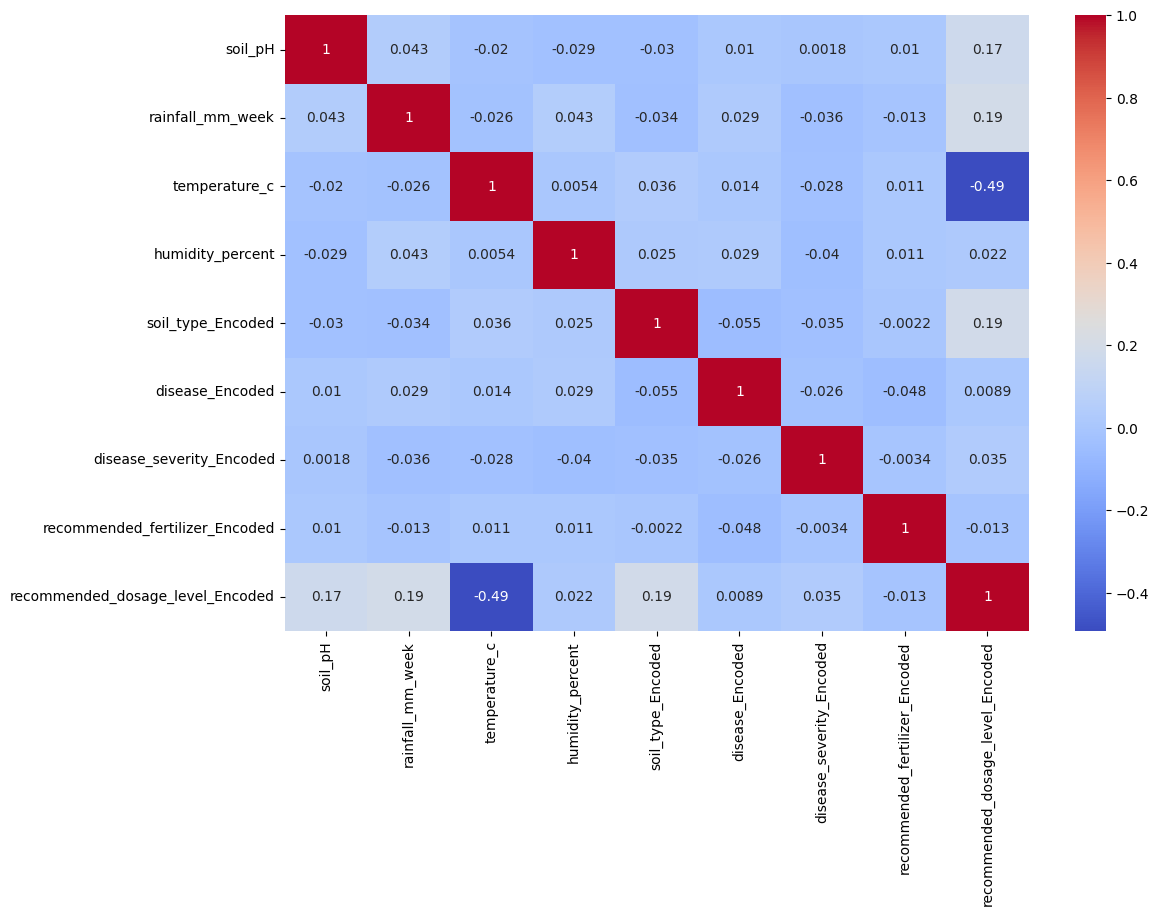

In [96]:
# 2. Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap="coolwarm")

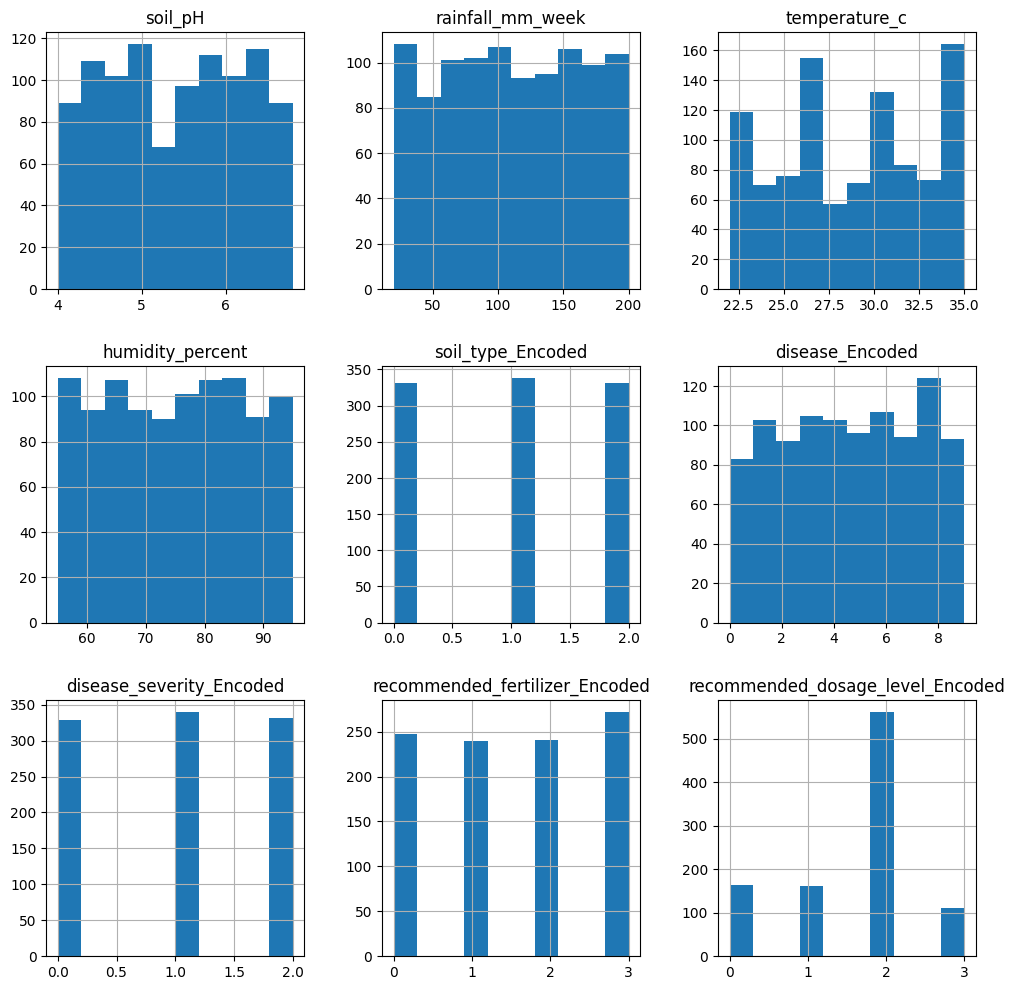

In [97]:
# 3. Distributions
df.hist(figsize=(12,12))
plt.show()


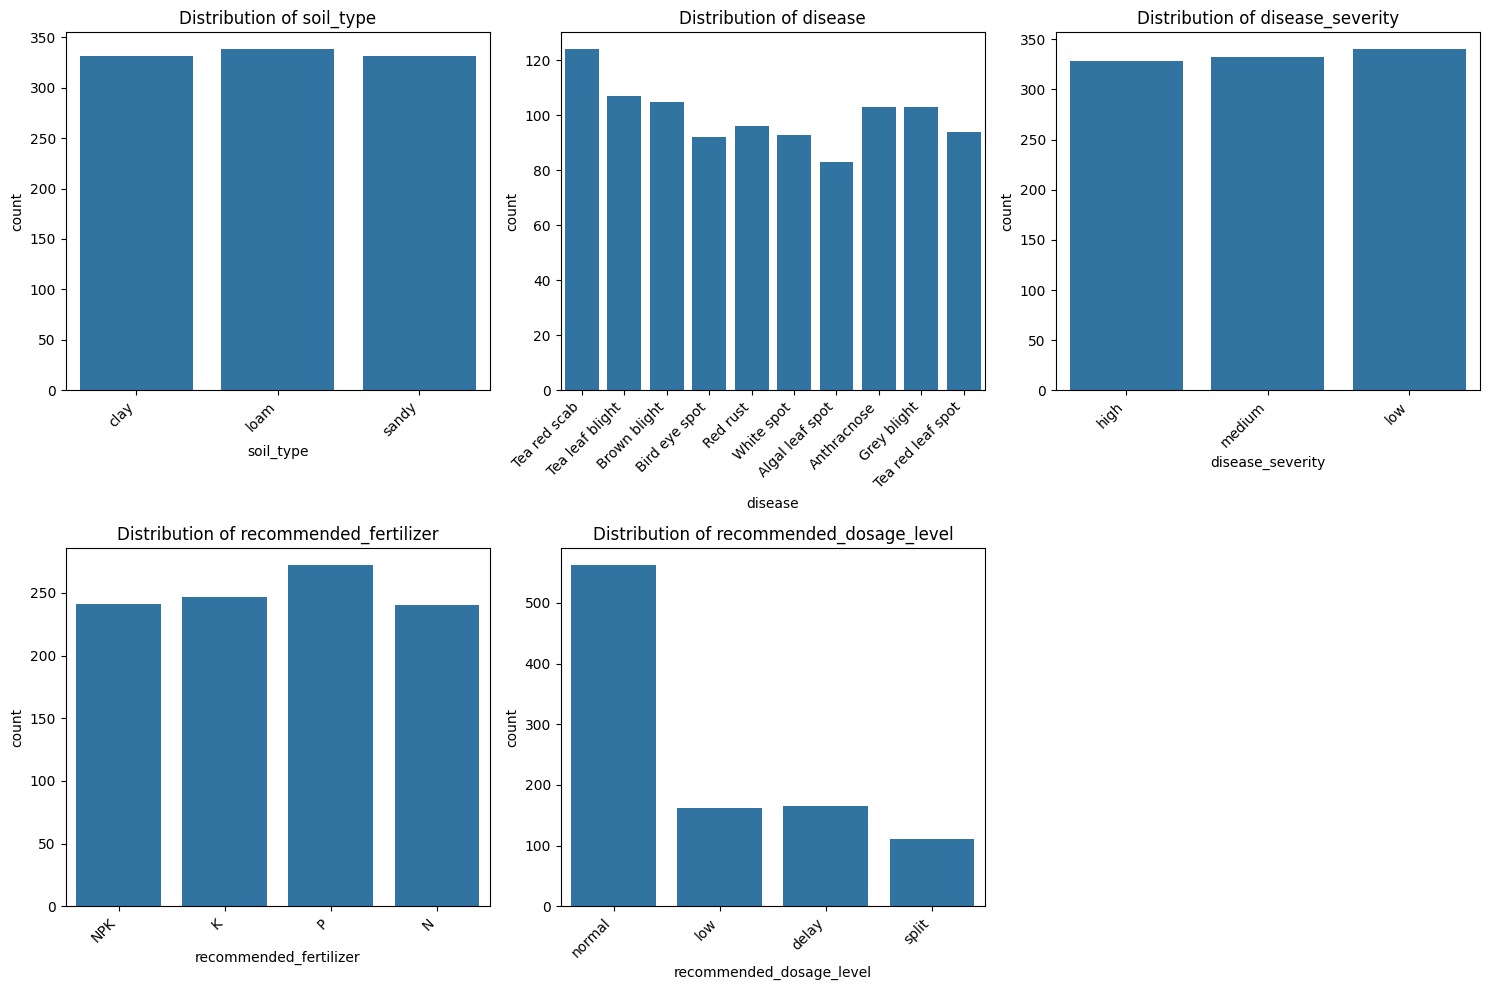

In [98]:
# Countplots for categorical columns
categorical_cols = ["soil_type", "disease", "disease_severity", "recommended_fertilizer", "recommended_dosage_level"]

plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols):
    plt.subplot(2, 3, i + 1) # Adjust subplot grid as needed
    sns.countplot(data=df, x=col)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

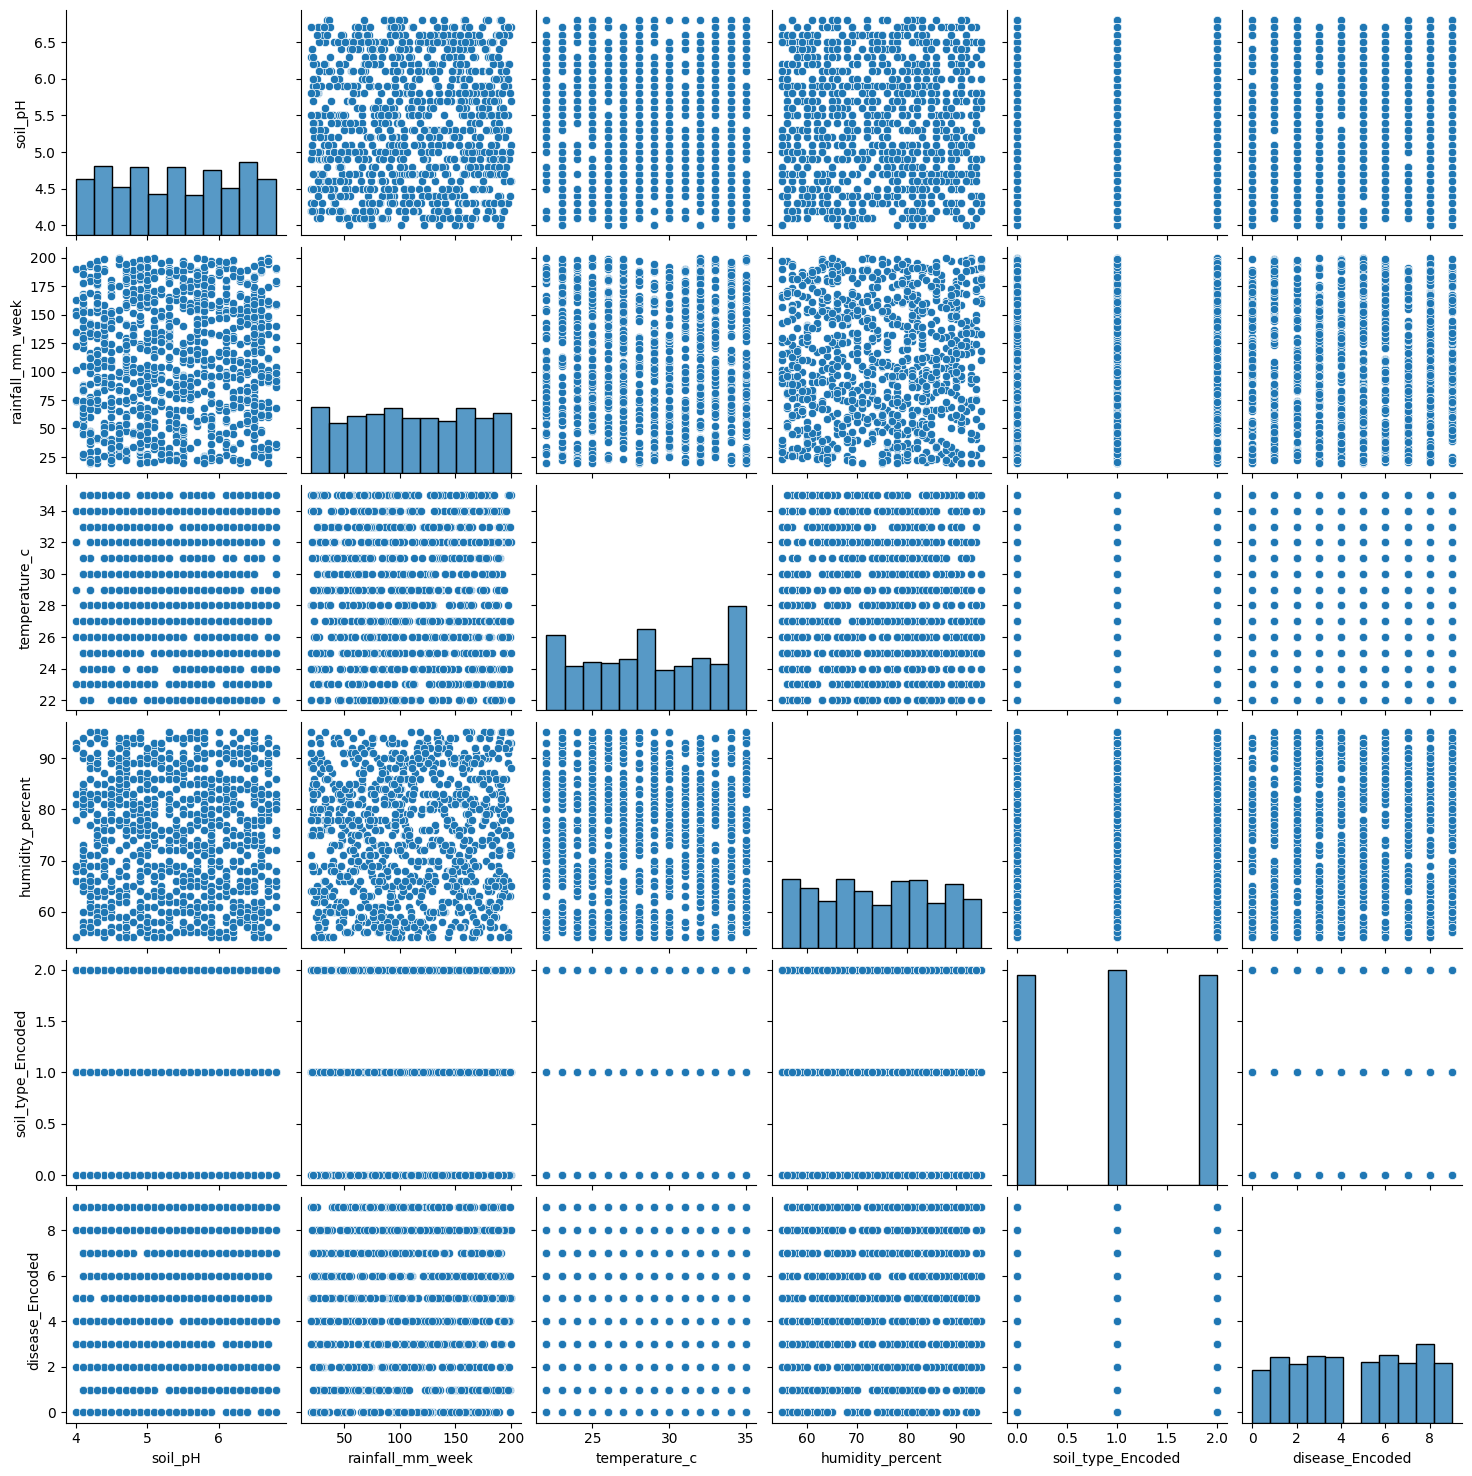

In [99]:

sns.pairplot(df[["soil_pH", "rainfall_mm_week", "temperature_c", "humidity_percent", "soil_type_Encoded", "disease_Encoded"]])
plt.show()

#Random Forest

In [100]:
le_fert = LabelEncoder()
le_dose = LabelEncoder()

y_train_enc = pd.DataFrame({
    "fertilizer": le_fert.fit_transform(y_train["recommended_fertilizer_Encoded"]),
    "dosage": le_dose.fit_transform(y_train["recommended_dosage_level_Encoded"])
})

y_test_enc = pd.DataFrame({
    "fertilizer": le_fert.transform(y_test["recommended_fertilizer_Encoded"]),
    "dosage": le_dose.transform(y_test["recommended_dosage_level_Encoded"])
})

In [101]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

cat_features = ["soil_type", "disease", "disease_severity"]
num_features = [
    "soil_pH",
    "rainfall_mm_week",
    "temperature_c",
    "humidity_percent"
]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
        ("num", StandardScaler(), num_features) # Apply StandardScaler to numerical features
    ]
)

In [102]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

model = MultiOutputClassifier(
    RandomForestClassifier(
        n_estimators=200,
        max_depth=12,
        min_samples_leaf=5,
        random_state=42
    )
)


In [103]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("prep", preprocessor),   # OneHotEncoder + numeric passthrough
    ("model", model)
])


Hyperparameter tuning

In [104]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

# Define the pipeline with preprocessor and MultiOutputClassifier
tuning_pipeline = Pipeline([
    ('prep', preprocessor),  # Use the preprocessor defined earlier
    ('clf', MultiOutputClassifier(RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
        )))
])

# Define parameters for GridSearchCV. These parameters now refer to the RandomForestClassifier within the pipeline.
params = {
    "clf__estimator__n_estimators": [100, 200, 300],
    "clf__estimator__max_depth": [5, 10, 20, None],
    "clf__estimator__min_samples_split": [2, 5, 10]
}
def custom_accuracy(y_true, y_pred):
    # subset accuracy: BOTH outputs must be correct
    return np.mean(np.all(y_true == y_pred, axis=1))

# Initialize GridSearchCV with the pipeline and parameters, using our custom_accuracy scorer
grid = GridSearchCV(tuning_pipeline, params, cv=3, n_jobs=-1, scoring=custom_accuracy) # Use the custom_accuracy scorer

# Fit GridSearchCV
grid.fit(X_train, y_train_enc) # Use y_train_enc as it's the processed target

print("Best Parameters:", grid.best_params_)
best_model = grid.best_estimator_

#OR
# grid = GridSearchCV(
#     pipeline,
#     param_grid=params,
#     cv=3,
#     scoring=custom_accuracy
# )

# grid.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Parameters: {'clf__estimator__max_depth': 5, 'clf__estimator__min_samples_split': 2, 'clf__estimator__n_estimators': 100}


In [105]:
#pipeline.fit(X_train, y_train)


In [106]:
y_pred = best_model.predict(X_test)


Evaluating random forest

In [107]:
from sklearn.metrics import classification_report

# Fit the pipeline before making predictions
pipeline.fit(X_train, y_train_enc)

y_pred = pipeline.predict(X_test)

print("FERTILIZER PREDICTION")
print(classification_report(y_test_enc["fertilizer"], y_pred[:, 0]))

print("\nDOSAGE PREDICTION")
print(classification_report(y_test_enc["dosage"], y_pred[:, 1]))

FERTILIZER PREDICTION
              precision    recall  f1-score   support

           0       0.26      0.27      0.27        44
           1       0.39      0.20      0.27        55
           2       0.27      0.17      0.21        54
           3       0.25      0.49      0.33        47

    accuracy                           0.28       200
   macro avg       0.29      0.28      0.27       200
weighted avg       0.30      0.28      0.26       200


DOSAGE PREDICTION
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        31
           2       1.00      1.00      1.00       110
           3       1.00      1.00      1.00        24

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



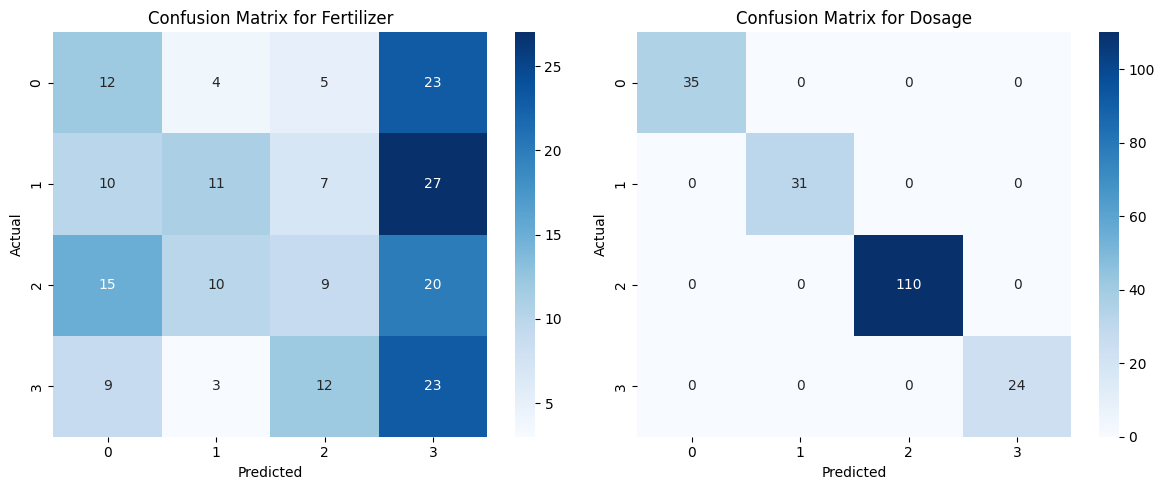

In [108]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get target names from y_test_enc (which has 'fertilizer' and 'dosage' columns)
target_names_eval = y_test_enc.columns.tolist()

plt.figure(figsize=(12, 5))

for i, target_name in enumerate(target_names_eval):
    plt.subplot(1, 2, i + 1) # Create subplots for each target
    cm = confusion_matrix(y_test_enc.iloc[:, i], y_pred[:, i])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {target_name.capitalize()}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.show()

#Decision tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn import tree
import matplotlib.pyplot as plt


X = df[[
    "Soil pH","Moisture (%)","Temp (°C)",
    "Leaf Color_Encoded","Leaf Texture_Encoded",
    "Pest Type_Encoded","Nutrient Deficiency_Encoded",
    "Soil_Acidic_Flag","Health_Score"
]]

# Target (change to Recommended Fertilizer if needed)
y = df["Recommended Pesticide"]

In [ ]:
#TRAIN TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
#TRAIN MODEL
dt = DecisionTreeClassifier(
    criterion="gini",
    max_depth=6,
    min_samples_split=4
)

dt.fit(X_train, y_train)

In [ ]:
#preds
y_pred = dt.predict(X_test)

In [ ]:
# --- EVALUATION ---
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [ ]:
# --- VISUALIZE TREE ---
plt.figure(figsize=(22,12))
tree.plot_tree(
    dt,
    feature_names=X.columns,
    class_names=dt.classes_,
    filled=True,
    fontsize=10
)
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=6, random_state=42)
dt.fit(X_train, y_train)

dt_pred = dt.predict(X_test)

#Decision tree and random forest comparison

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

print("DECISION TREE ACCURACY:", accuracy_score(y_test, dt_pred))
print("\nDECISION TREE CLASSIFICATION REPORT:\n", classification_report(y_test, dt_pred))

print("RANDOM FOREST ACCURACY:", accuracy_score(y_test, rf_pred))
print("\nRANDOM FOREST CLASSIFICATION REPORT:\n", classification_report(y_test, rf_pred))


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(y_test, dt_pred), annot=True, cmap="Reds")
plt.title("Decision Tree Confusion Matrix")

plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(y_test, rf_pred), annot=True, cmap="Blues")
plt.title("Random Forest Confusion Matrix")

plt.show()


try bagging and boosting methods

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize a base estimator (e.g., Decision Tree)
bc = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42), n_estimators=100, random_state=42)

# Train the BaggingClassifier
bc.fit(X_train, y_train)

# Make predictions
bc_pred = bc.predict(X_test)

# Evaluate the model
print("BAGGGING CLASSIFIER ACCURACY:", accuracy_score(y_test, bc_pred))
print("\nBAGGGING CLASSIFIER CLASSIFICATION REPORT:\n", classification_report(y_test, bc_pred))

In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize base estimator (RandomForestClassifier)
rf_bagging = BaggingClassifier(estimator=RandomForestClassifier(random_state=42), n_estimators=100, random_state=42)

# Train the BaggingClassifier with RandomForest
rf_bagging.fit(X_train, y_train)

# Make predictions
rf_bagging_pred = rf_bagging.predict(X_test)

print("RANDOM FOREST BAGGING ACCURACY:", accuracy_score(y_test, rf_bagging_pred))
print("\nRANDOM FOREST BAGGING CLASSIFICATION REPORT:\n", classification_report(y_test, rf_bagging_pred))

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import numpy as np

# Initialize LabelBinarizer
label_binarizer = LabelBinarizer()
y_test_binarized = label_binarizer.fit_transform(y_test)

# Get predicted probabilities from the best performing model (rf_bagging)
y_pred_proba = rf_bagging.predict_proba(X_test)

# Plot ROC AUC for each class
plt.figure(figsize=(10, 8))
for i in range(len(label_binarizer.classes_)):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve of class {label_binarizer.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize and train the Gradient Boosting Classifier
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbc.fit(X_train, y_train)

# Make predictions
gbc_pred = gbc.predict(X_test)

# Evaluate the model
print("GRADIENT BOOSTING CLASSIFIER ACCURACY:", accuracy_score(y_test, gbc_pred))
print("\nGRADIENT BOOSTING CLASSIFIER CLASSIFICATION REPORT:\n", classification_report(y_test, gbc_pred))

In [ ]:
sns.heatmap(confusion_matrix(y_test, gbc_pred), annot=True, cmap="Blues")
plt.title("Random Forest Confusion Matrix")

plt.show()

In [ ]:
from sklearn.model_selection import learning_curve

rf_model = RandomForestClassifier()

train_sizes, train_scores, val_scores = learning_curve(
    rf_model, X, y, cv=5, scoring='accuracy'
)

train_error = 1 - np.mean(train_scores, axis=1)
val_error = 1 - np.mean(val_scores, axis=1)

plt.plot(train_sizes, train_error, label="Training Loss")
plt.plot(train_sizes, val_error, label="Validation Loss")
plt.title("Learning Curve for Random Forest")
plt.xlabel("Training Set Size")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
dt_model = DecisionTreeClassifier()

train_sizes, train_scores, val_scores = learning_curve(
    dt_model, X, y, cv=5, scoring='accuracy'
)

train_error = 1 - np.mean(train_scores, axis=1)
val_error = 1 - np.mean(val_scores, axis=1)

plt.plot(train_sizes, train_error, label="Training Loss")
plt.plot(train_sizes, val_error, label="Validation Loss")
plt.title("Learning Curve for Decision Tree")
plt.xlabel("Training Set Size")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import log_loss

val_loss_gb = []

for y_pred_proba_stage in gbc.staged_predict_proba(X_test):
    loss = log_loss(y_test_binarized, y_pred_proba_stage)
    val_loss_gb.append(loss)

print("Validation Loss at each boosting stage (GradientBoostingClassifier):")
print(val_loss_gb[:5]) # Print first 5 losses as an example

In [ ]:
train_loss_gb = []

for y_pred_proba_stage in gbc.staged_predict_proba(X_train):
    loss = log_loss(label_binarizer.fit_transform(y_train), y_pred_proba_stage)
    train_loss_gb.append(loss)


# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss_gb) + 1), train_loss_gb, label='Training Loss')
plt.plot(range(1, len(val_loss_gb) + 1), val_loss_gb, label='Validation Loss')
plt.xlabel('Number of Boosting Stages')
plt.ylabel('Log Loss')
plt.title('Learning Curve for Gradient Boosting Classifier')
plt.legend()
plt.grid(True)
plt.show()

### Plotting Precision-Recall Curves for Decision Tree and Random Forest

We will now generate and plot the Precision-Recall Curves (PRC) for each model. This involves:
1.  Identifying the correct feature sets and splitting the data for each model.
2.  Obtaining prediction probabilities from the trained models.
3.  Calculating precision, recall, and thresholds using `precision_recall_curve`.
4.  Plotting the curves for each class and calculating the Average Precision (AP) score.

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import numpy as np

# Helper function to plot PRC for multi-class
def plot_multiclass_prc(y_test_binarized, y_pred_proba, class_names, title):
    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(class_names):
        precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_pred_proba[:, i])
        ap = average_precision_score(y_test_binarized[:, i], y_pred_proba[:, i])
        plt.plot(recall, precision, label=f'Class {class_name} (AP = {ap:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

In [ ]:
# --- Decision Tree Model Setup (re-split for clarity) ---
X_dt = df[[
    "Soil pH","Moisture (%)","Temp (°C)",
    "Leaf Color_Encoded","Leaf Texture_Encoded",
    "Pest Type_Encoded","Nutrient Deficiency_Encoded",
    "Soil_Acidic_Flag","Health_Score"
]]
y_dt = df["Recommended Pesticide"]

X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(
    X_dt, y_dt, test_size=0.2, random_state=42, stratify=y_dt
)

# Ensure the DT model is fitted on this specific split
dt_prc = DecisionTreeClassifier(max_depth=6, random_state=42) # Using the parameters from previous training
dt_prc.fit(X_train_dt, y_train_dt)
y_pred_proba_dt = dt_prc.predict_proba(X_test_dt)

# Binarize y_test_dt
label_binarizer_dt = LabelBinarizer()
y_test_dt_binarized = label_binarizer_dt.fit_transform(y_test_dt)
class_names_dt = label_binarizer_dt.classes_

In [ ]:
# Plot PRC for Decision Tree
plot_multiclass_prc(
y_test_dt_binarized, y_pred_proba_dt, class_names_dt, 'Precision-Recall Curve for Decision Tree'
)

In [ ]:
# --- Random Forest Model Setup (re-split for clarity) ---
features_rf = [
    "Soil pH", "Moisture (%)", "Temp (°C)",
    "Soil_Acidic_Flag", "pH_Deviation", "Temp_Normalized",
    "Moisture_Normalized", "Health_Score",
    "Moisture_Temp_Interaction", "pH_Deficiency_Interaction",
    "Leaf Color_Encoded", "Leaf Texture_Encoded",
    "Pest Type_Encoded", "Nutrient Deficiency_Encoded"
]
X_rf = df[features_rf]
y_rf = df["Recommended Pesticide"]

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_rf, y_rf, test_size=0.2, random_state=42 # Not stratifying here to match original RF split
)

# Scale X_test_rf as the RF model was likely trained with scaled data based on previous steps
# Note: The original RF model in 'ZKxdDs1A9jbL' was fitted on X_train (not scaled), but then scaled for cross-validation in D88QDJURLv2Y. Let's use unscaled X_test_rf to align with the rf.fit(X_train, y_train) from ZKxdDs1A9jbL which is not explicitly scaled.
# If the model 'rf' was trained on X_train_scaled, this would be incorrect. Let's re-train 'rf' using unscaled X_train_rf to be consistent, or apply the scaler here.
# Checking cell ZKxdDs1A9jbL: `rf.fit(X_train, y_train)` uses unscaled data. So no scaling needed for X_test_rf here.

rf_prc = RandomForestClassifier(n_estimators=200, random_state=42) # Using best parameters from grid search
rf_prc.fit(X_train_rf, y_train_rf)
y_pred_proba_rf = rf_prc.predict_proba(X_test_rf)

# Binarize y_test_rf
label_binarizer_rf = LabelBinarizer()
y_test_rf_binarized = label_binarizer_rf.fit_transform(y_test_rf)
class_names_rf = label_binarizer_rf.classes_

In [ ]:
# Plot PRC for Random Forest
plot_multiclass_prc(
y_test_rf_binarized, y_pred_proba_rf, class_names_rf, 'Precision-Recall Curve for Random Forest'
)

# Task
Modify the code in cell `k0kBiqhhK6Hr` to use the correct categorical columns for Label Encoding based on the new dataset.

## modify_cells

### Subtask:
Modify the code in cell `k0kBiqhhK6Hr` to use the correct categorical columns for Label Encoding based on the new dataset.


## Summary:

### Data Analysis Key Findings
- The current step is focused on updating the data preprocessing code rather than performing new data analysis.
- The primary task is to modify the existing Label Encoding implementation in cell `k0kBiqhhK6Hr` to align with the categorical columns present in a new dataset.

### Insights or Next Steps
- The immediate next step is to identify the specific categorical columns within the new dataset that require Label Encoding.
- The identified columns will then be used to update the code in cell `k0kBiqhhK6Hr` to ensure correct application of Label Encoding.
